## This is an algorithm development playground for UBS Quant contest

In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential, Model, load_model
from keras.layers import Dense
from keras.layers import LSTM, GRU, Conv1D, MaxPooling1D, Flatten, TimeDistributed, Concatenate
from keras.layers import GaussianNoise, BatchNormalization, Dropout
from keras.layers import Activation, merge, Input, concatenate, Reshape, add
from keras.optimizers import Adam, SGD
from keras.regularizers import l1, l2
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.callbacks import Callback, LambdaCallback, TensorBoard, ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from keras.utils import np_utils, to_categorical
from keras.utils.vis_utils import plot_model 
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
import time
%matplotlib inline

Using TensorFlow backend.


In [2]:
def df_alginer(dfs):
    # get all columns
    index_seq = []
    for df in dfs:
        index_seq += list(df.columns)
    
    # concatenate and align
    tmp = pd.concat(dfs, axis=1, join="inner")
    tmp = tmp.reindex(columns=index_seq)
    
    # retrieve pds back
    for i in range(0, len(dfs)):
        dfs[i] = tmp.iloc[:, sum([len(dfs[j].columns) for j in range(0, i)])
                          :sum([len(dfs[j].columns) for j in range(0, i+1)])]
    return dfs

In [3]:
def moving_average(df, window_size=5):
    """
    Do move average on window_size
    """
    out = df.copy()
    
    # do window_size moving average
    for i in range(window_size, len(df)+1):
        out.iloc[i-1, :] = df.iloc[i-window_size:i, :].mean()
    
    return out.iloc[window_size-1:, :]

def moving_normalize(df, mean_window_size=520, future_window_size=40):
    """
    Due to the fact that index is constantly growing, using a universal normalizing method is infeasible.
    The function use mean_window_size to calculate mean, and use the mean to divide future_window_size data.
    """
    out = df.copy()
    
    for i in range(mean_window_size, len(df)-future_window_size, future_window_size):
        out.iloc[i:i+future_window_size, :] = df.iloc[i:i+future_window_size, :] / df.iloc[i-mean_window_size:i, :].mean()
    
    i = i-future_window_size
    if not i == len(df)-future_window_size-1:
        out.iloc[i:, :] = df.iloc[i:, :] / df.iloc[i-mean_window_size:i, :].mean()
    
    return out.iloc[mean_window_size:, :] - 1

In [85]:
def generate_train_data(df, raw_df, test_split=0.2, valid_split=0.1, input_len=20, output_len=10):
    """
    input is a sequence of length input_len
    output is a single value mean of length output_len
    """
    def process_index(i):
        if i > 0.005:
            return 1
        elif i < -0.005:
            return 0
        else:
            return 0
    process_index = np.vectorize(process_index)
    
    
    out = {}
    
    data_len = len(df)-output_len
    test_split_len = int(data_len*(1-test_split-valid_split))
    valid_split_len = int(data_len*(1-valid_split))
    
    out["train_input"] = np.array([df.iloc[i-input_len:i, :].values for i in range(input_len, test_split_len)])
    out["train_output_index"] = process_index(np.array(
        [raw_df.iloc[i:i+output_len, [0, 3]].mean(axis=1).mean() / raw_df.iloc[i-output_len:i, [0, 3]].mean(axis=1).mean() - 1 
         for i in range(input_len, test_split_len)]))
    out["train_output_max"] = np.array([df.iloc[i:i+output_len, 1].max() for i in range(input_len, test_split_len)])
    out["train_output_min"] = np.array([df.iloc[i:i+output_len, 2].min() for i in range(input_len, test_split_len)])
    
    out["test_input"] = np.array([df.iloc[i-input_len:i, :].values for i in range(test_split_len, valid_split_len)])
    out["test_output_index"] = process_index(np.array(
        [raw_df.iloc[i:i+output_len:i, [0, 3]].mean(axis=1).mean() / raw_df.iloc[i-output_len:i, [0, 3]].mean(axis=1).mean() - 1 
         for i in range(test_split_len, valid_split_len)]))
    out["test_output_max"] = np.array([df.iloc[i:i+output_len, 1].max() for i in range(test_split_len, valid_split_len)])
    out["test_output_min"] = np.array([df.iloc[i:i+output_len, 2].min() for i in range(test_split_len, valid_split_len)])
    
    out["valid_input"] = np.array([df.iloc[i-input_len:i, :].values for i in range(valid_split_len, data_len)])
    out["valid_output_index"] = process_index(np.array(
        [raw_df.iloc[i:i+output_len, [0, 3]].mean(axis=1).mean() / raw_df.iloc[i-output_len:i, [0, 3]].mean(axis=1).mean() - 1 
         for i in range(valid_split_len, data_len)]))
    out["valid_output_max"] = np.array([df.iloc[i:i+output_len, 1].max() for i in range(valid_split_len, data_len)])
    out["valid_output_min"] = np.array([df.iloc[i:i+output_len, 2].min() for i in range(valid_split_len, data_len)])
    
    return out

In [86]:
# read the factor time data
df = pd.read_csv("^GSPC.csv", index_col=[0], parse_dates=[0]).iloc[1:, :-1]

# normalize data
input_len = 100
output_len = 10
normalized_df = moving_normalize(df, mean_window_size=520, future_window_size=40)
input_df = normalized_df.iloc[:, [0, 1, 2, 3]]

In [87]:
train_data = generate_train_data(input_df, df, test_split=0.2, valid_split=0.1, input_len=input_len, output_len=output_len)

In [88]:
train_data['train_output_index'].mean()

0.49557674138967622

In [89]:
# flow for prev_label_input
seq_input = Input(shape=(input_len, 4))
x = seq_input
lstm_feature = LSTM(units=128, activation="relu", kernel_regularizer=l2(l=0.01), return_sequences=False)(x)

x = Dense(units=64)(lstm_feature)
x = Dropout(rate=0.2)(x)
output_max = Dense(units=1, activation="tanh")(x)

x = Dense(units=64)(lstm_feature)
x = Dropout(rate=0.2)(x)
output_min = Dense(units=1, activation="tanh")(x)

x = Dense(units=64)(lstm_feature)
x = Dropout(rate=0.2)(x)
output_index = Dense(units=1, activation="tanh")(x)

# compile model
Indexer = Model(inputs=[seq_input], outputs=[output_max, output_min, output_index])
Indexer.compile(loss="logcosh", optimizer=Adam(lr=0.005), metrics=["mse"])

# display model
plot_model(model=Indexer, to_file="temp.png")
Indexer.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 100, 4)       0                                            
__________________________________________________________________________________________________
lstm_7 (LSTM)                   (None, 128)          68096       input_7[0][0]                    
__________________________________________________________________________________________________
dense_37 (Dense)                (None, 64)           8256        lstm_7[0][0]                     
__________________________________________________________________________________________________
dense_39 (Dense)                (None, 64)           8256        lstm_7[0][0]                     
__________________________________________________________________________________________________
dense_41 (

In [90]:
Indexer.fit(x=train_data["train_input"], 
            y=[train_data['train_output_max'], train_data['train_output_min'], train_data['train_output_index']], 
            validation_data=[train_data["test_input"], 
              [train_data["test_output_max"], train_data["test_output_min"], train_data["test_output_index"]]],
            epochs=300, batch_size=64, shuffle=True, verbose=1)

Train on 11643 samples, validate on 3356 samples
Epoch 1/300
11643/11643 [==============================] - 19s 2ms/step - loss: 0.1274 - dense_38_loss: 6.5102e-04 - dense_40_loss: 7.8016e-04 - dense_42_loss: 0.1219 - dense_38_mean_squared_error: 0.0013 - dense_40_mean_squared_error: 0.0016 - dense_42_mean_squared_error: 0.2548 - val_loss: 0.1215 - val_dense_38_loss: 3.1287e-04 - val_dense_40_loss: 6.8127e-04 - val_dense_42_loss: 0.1203 - val_dense_38_mean_squared_error: 6.2605e-04 - val_dense_40_mean_squared_error: 0.0014 - val_dense_42_mean_squared_error: 0.2505
Epoch 2/300
11643/11643 [==============================] - 18s 2ms/step - loss: 0.1222 - dense_38_loss: 4.5260e-04 - dense_40_loss: 6.2847e-04 - dense_42_loss: 0.1208 - dense_38_mean_squared_error: 9.0580e-04 - dense_40_mean_squared_error: 0.0013 - dense_42_mean_squared_error: 0.2520 - val_loss: 0.1257 - val_dense_38_loss: 3.2520e-04 - val_dense_40_loss: 7.3526e-04 - val_dense_42_loss: 0.1244 - val_dense_38_mean_squared_error

KeyboardInterrupt: 

### Currently the system is overfitting to the average
### The following methods are to be attempted
1. Try to remove corelated input features
2. Simplify the current network in a proper way

In [91]:
def compare_output(predicted, correct, title):
    x = np.arange(0, correct.shape[0])
    plt.figure(figsize=(22, 2))
    plt.title(title)
    sample_label, = plt.plot(x, correct, label="sample")
    predict_label, = plt.plot(x, predicted, label="predict")
    plt.legend([sample_label, predict_label], ["sample", "predict"])
    plt.plot()

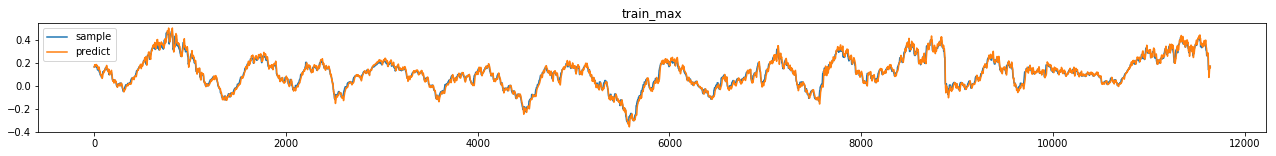

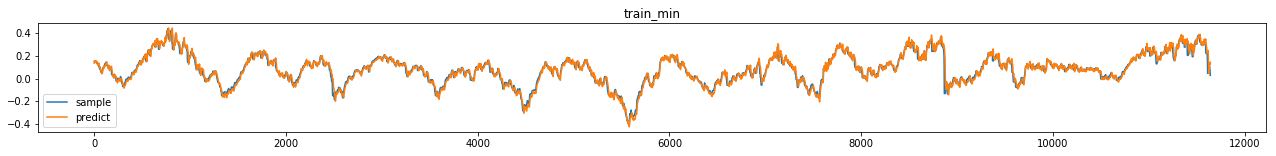

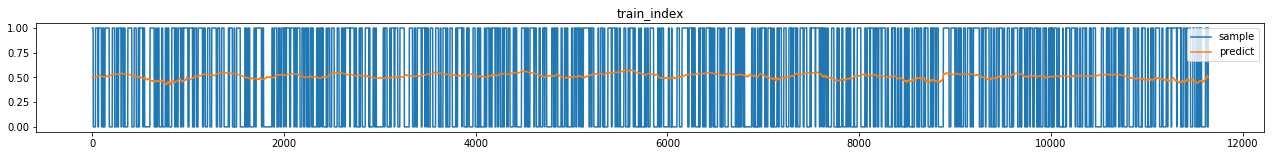

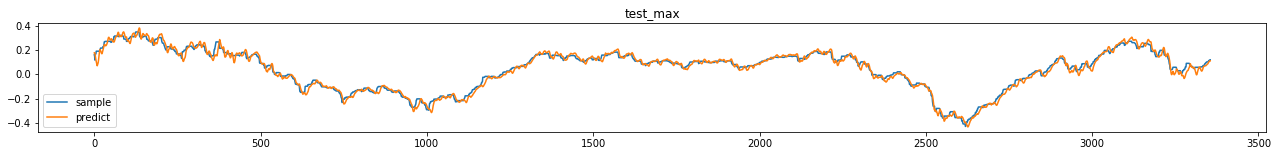

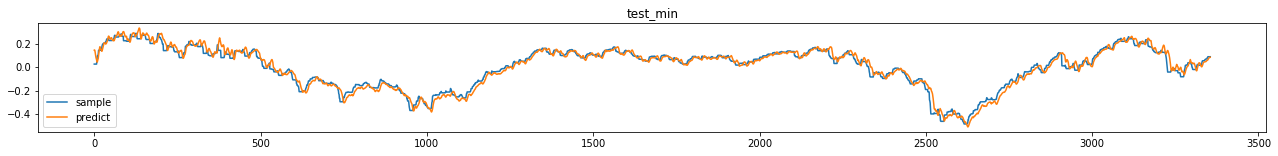

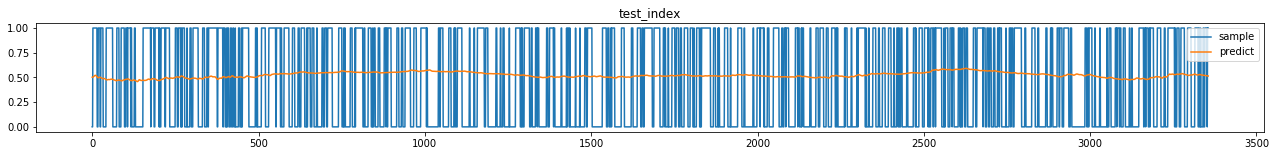

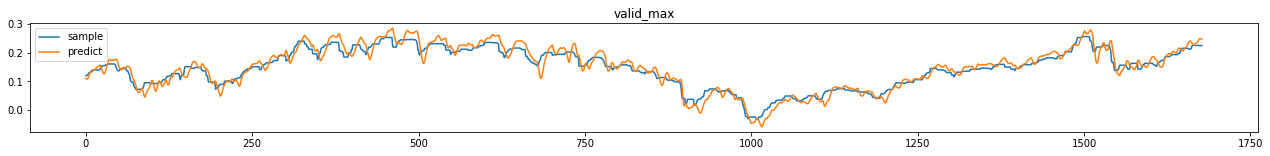

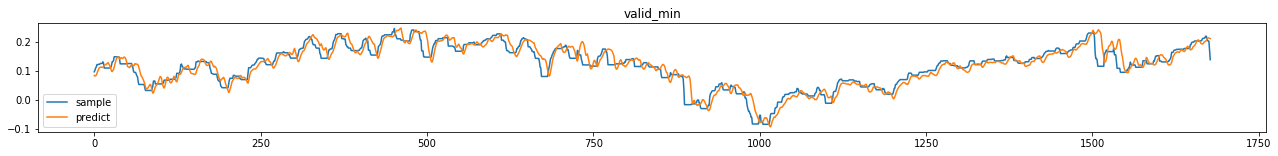

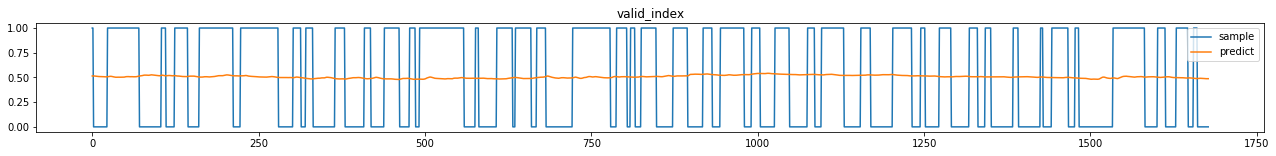

In [92]:
for which in ["train", "test", "valid"]:
    predicted = Indexer.predict_on_batch([train_data[which+'_input']])
    correct = train_data[which+'_output_max']
    compare_output(predicted[0], correct, which+'_max')
    correct = train_data[which+'_output_min']
    compare_output(predicted[1], correct, which+"_min")
    correct = train_data[which+'_output_index']
    compare_output(predicted[2], correct, which+"_index")